## Abstract

In this notebook, a reinforcement learning agent is trained to take controll over the managment of the pharmacy inventory. It is hoped that the inventory is thereby optimized for drug availability. Basis for the training is a set of recorded transactions in the pharmacy from 2004 to 2022 are used. The dataset is queried from a local PostgreSQL database.

## Preperation

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2 as pg
import random
from sqlalchemy import create_engine
import squarify
import tensorflow as tf
from tensorflow import keras

# Establish connection to Postgresql-database
connection = pg.connect("host=localhost dbname=pharmacy user=postgres password=projectds")

#### Viable drugs

There are over 100,000 drugs that can be acquired in a pharmacy in Germany. For simplicity, only drugs stored in the general alphabet of the inventory are taken into account. These drugs are likely to be prescription drugs. Different to drugstore items (candy, cosmetics, dietary supplements), they are mainly ordered in small quantities from a wholesaler.

In [2]:
drugs_df = pd.io.sql.read_sql(""" 
SELECT *
FROM arzneimittel
WHERE apothekenpflichtig = True
""", connection)

In [3]:
locations_dict = {
    "A": "G",
    "B": "G",
    "BTM": "BTM",
    "C": "C",
    "CF": "F",
    "CG": "C",
    "E": "G",
    "F": "F",
    "FC": "F",
    "FG": "F",
    "FO": "F",
    "G": "G",
    "GC": "C",
    "GM": "G",
    "K": "K",
    "M": "G",
    "MK": "K",
    "N": "G",
    "NK": "K",
    "R": "R",
    "RK": "R",
    "T": "G",
    "V": "V",
    "VG": "V",
    "X": "X",
    "XC": "X",
    "XF": "X",
    "VGF": "V",
    "XVG": "X",
    "NC": "C",
    "XV": "X",
    "NF": "F",
    "VN": "V",
    "XG": "X",
    "CGO": "C",
    None: "X"
}

drugs_df['lagerort'] = drugs_df['lagerort'].map(lambda x: locations_dict[x])
drugs_df = drugs_df.loc[drugs_df['lagerort'].isin(["G", "X"])]
display(drugs_df)

drugs_list = drugs_df['pzn'].tolist()
drugs_array = drugs_df['pzn'].to_numpy()

,pzn,bezeichnung,herkue,darr,menge,warengruppe,me,rezeptflichtig,apothekenpflichtig,lagerort
0,112,ACALYPHA indica D 3 Globuli,DHU,GLO,10,BX01,G,False,True,X
1,313,BAMBUSA D 1 Globuli,DHU,GLO,10,BX01,G,False,True,X
2,460,CHIMAPHILA UMBELLATA D 12 Tabletten,DHU,TAB,80,BX01,ST,False,True,X
3,1353,ENDOFALK Tropic Plv.z.Her.e.Lsg.z.Einn.Btl.,FALKP,PLE,8,AA06AD65,ST,False,True,X
4,1382,MYRISTICA SEBIFERA D 3 Dilution,DHU,DIL,20,BX01,ML,False,True,X
...,...,...,...,...,...,...,...,...,...,...
23060,17445321,IBUPROFEN ADGC 400 mg Filmtabletten,ZENTI,FTA,50,AM01AE01,ST,False,True,X
23061,17502473,PARACETAMOL ADGC 500 mg Tabletten,ZENTI,TAB,10,AN02BE01,ST,False,True,X
23062,17502496,PARACETAMOL ADGC 500 mg Tabletten,ZENTI,TAB,20,AN02BE01,ST,False,True,X
23063,17526410,ACETYLSALICYLSÃ„URE ADGC 500 mg Tabletten,ZENTI,TAB,30,AN02BA01,ST,False,True,G


#### Transactions

In [4]:
transaction_df = pd.io.sql.read_sql(""" 
SELECT datum, uhrzeit, pzn, anzahl
FROM transaktion
WHERE retoure = False;
""", connection)

transaction_df = transaction_df.loc[transaction_df['pzn'].isin(drugs_list)]
transaction_df = transaction_df.set_index(['datum', 'uhrzeit'])


display(transaction_df)

pzn  anzahl
datum      uhrzeit                  
2004-01-02 09:08:00  6997885       1
           09:09:00  7555072       1
           09:10:00  4827647       2
           09:20:00  4085341       1
           09:21:00  8625053       1
...                      ...     ...
2021-12-31 13:30:00  1696788       1
           13:30:00  2634097       1
           13:30:00  4884527       1
           13:42:00  9231480       1
           13:42:00  3140380       1

[999380 rows x 2 columns]

In [5]:
transaction_dates = transaction_df.index.get_level_values('datum').drop_duplicates()
print(transaction_dates)

Index([2004-01-02, 2004-01-03, 2004-01-05, 2004-01-07, 2004-01-08, 2004-01-09,
       2004-01-10, 2004-01-12, 2004-01-13, 2004-01-14,
       ...
       2021-12-20, 2021-12-21, 2021-12-22, 2021-12-23, 2021-12-24, 2021-12-27,
       2021-12-28, 2021-12-29, 2021-12-30, 2021-12-31],
      dtype='object', name='datum', length=5650)


#### Inventory snapshots

In [6]:
inventory_dict = {}
for year in range (2007, 2022, 1):
    data = pd.read_csv (f'../exploration/data/inventory/{year}.csv', delimiter=';', dtype={
        'PZN': 'str',
        'Bestand': 'int'
    })
    df = pd.DataFrame(data)
    df = df.loc[df['PZN'].isin([str(pzn) for pzn in drugs_list])]
    df['PZN'] = df['PZN'].astype('int')
    inventory_dict[year] = df

## Modelling

The environment the agent is placed in is abstracted from the real pharmacy setting. Within the environment, the agent can choose from a set of viable actions. Each action results in the agent receiving some sort of reward or punishment. The goal of the agent is to maximize the reward amount over time. 

### Create Environment

#### Assumptions

In [7]:
max_space = 5000  # Number of drugs that can be stored in the pharmacy
days_until_expiration = 365  # Number of days until a stored drug is expiring

delivery_times = [  # List with daytimes, were the wholesale is delivering ordered drugs
    [datetime.time(9, 0, 0), datetime.time(12, 0, 0)],
    [datetime.time(12, 0, 0), datetime.time(15, 0, 0)],
    [datetime.time(15, 0, 0), datetime.time(18, 0, 0)],
    [datetime.time(18, 0, 0), datetime.time(20, 0, 0)],
]

The values were choosen using domain knowledge as well as the insights from the exploration of the inventory data.

#### Inventory initialization

In [8]:
def inventory_init(num_vailable_drugs, max_space):


    inventory_array = np.zeros(shape=num_vailable_drugs, dtype=int)
    print(inventory_array)
    
    while np.sum(inventory_array) < max_space:
        single_order = np.random.randint(inventory_array.shape[0])
        inventory_array[single_order] += 1
        
    return inventory_array 

In [9]:
initital_inventory = inventory_init(drugs_array.shape[0], max_space)
print(initital_inventory.shape)
print(f"Number of drugs in initital inventory: {np.sum(initital_inventory)}")

[0 0 0 ... 0 0 0]
(22547,)
Number of drugs in initital inventory: 5000


#### Reward definition

In [10]:
reward_transaction_successful = 1
reward_transaction_failed = -1

#### Policy set up

The policy represents the algorithm on which the agent's decision is based on. Theoretically, any algorithm can be used. In practice however, one wants to choose an algorithm with trainable parameters. A neural network (Mulitlayer Perceptron, abbreviated MLP) fullfils this condition and is widely used in the sphere of machine learning. The MLP is provided with a snapshot of the current inventory as input. Based on that, it calculates which drug should be ordered to receive the reward in the future. 

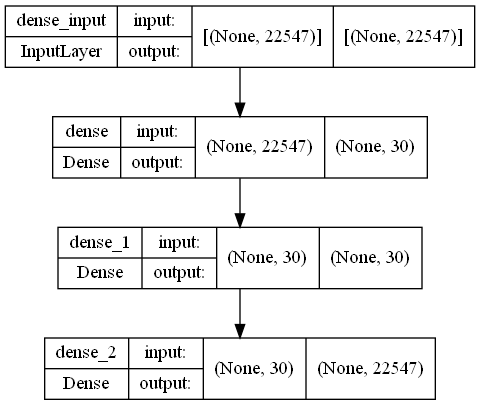

In [11]:
# sequential API

policy_model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", input_shape=[drugs_array.shape[0]]),
    keras.layers.Dense(30, activation="elu"),
    keras.layers.Dense(drugs_array.shape[0], activation="softmax")
])

policy_model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])


tf.keras.utils.plot_model(policy_model, 'visualizations/dqn_architecture.png', show_shapes=True)

### Training

After the agent is deployed within the environment, the transactions that actually occurred in the pharmacy from 2004 until 2022 are re-simulated. In the beginning, the agent is choosen actions mainly at random because the weights of the MLP are randomly initialized. Through rewards and punishment, the agent learns which actions are likely to optimize the reward over time.

In [12]:
def pzn_to_array (pzn):
    
    pzn_series = drugs_df['pzn'].apply(lambda x: 1 if x == pzn else 0)
    pzn_array = pzn_series.to_numpy()
    
    return pzn_array

In [13]:
def restock_inventory (inventory_array, epsilon=0):
    
    action_array = np.zeros(shape=inventory_array.shape, dtype=int)
    while np.sum(inventory_array) < max_space:
        prediction = policy_model.predict(np.reshape(inventory_array, (1, -1)))
        if np.random.rand() < epsilon:
            single_order = np.random.randint(inventory_array.shape[0])
        else:
            prediction_probabilities = prediction.copy()
            prediction_probabilities[prediction_probabilities<0] = 0
            np.nan_to_num(prediction_probabilities, copy=False)
            if prediction_probabilities.sum() != 0:
                prediction_probabilities = prediction_probabilities/prediction_probabilities.sum()
                single_order = np.random.choice(np.arange(prediction.shape[1]), 1, p=prediction_probabilities.flatten())[0]
            else:
                single_order = np.random.choice(np.arange(prediction.shape[1]), 1)[0]
            
        action_array[single_order] += 1
        inventory_array[single_order] += 1  
        
    return inventory_array, action_array

In [14]:
def perform_transactions (inventory_array, list_of_transactions):

    number_of_transaction = len(list_of_transactions)
    for transaction in list_of_transactions:   
        inventory_array = inventory_array-transaction    
    failed_transactions = abs(np.sum(inventory_array[inventory_array < 0]))
    successful_transactions = number_of_transaction - failed_transactions
    rewards_collected = successful_transactions*reward_transaction_successful + failed_transactions*reward_transaction_failed
    inventory_array[inventory_array < 0] = 0
    
    return inventory_array, rewards_collected, successful_transactions, failed_transactions

In [15]:
def single_out_transactions (row, df_to_apply):

    anzahl = row.anzahl
    if anzahl > 1:
        for i in range(anzahl-1):
            df_to_apply.loc[row.name+1000] = row

In [16]:
def sample_from_experience (experiences, sample_size, random_share):
    
    amount_random = round(sample_size*random_share)
    amount_latest = sample_size-amount_random
    sample_experience = experiences[-amount_latest:]
    for i in range(amount_random):
        sample_experience.append(random.choice(experiences))
    
    return sample_experience

In [17]:
def assign_reward_to_action (inventory_array, action_array, list_of_transactions):
    
    reward_array = np.zeros(shape=inventory_array.shape, dtype=int)
    for transaction in list_of_transactions:
        transaction_indize = transaction.nonzero()
        if inventory_array[transaction_indize] == 0 and action_array[transaction_indize] > 0:  # Action enabled transaction
            reward_array[transaction_indize] += reward_transaction_successful
        elif inventory_array[transaction_indize] == 0 and action_array[transaction_indize] == 0:  # Right action was not performed
            reward_array[transaction_indize] += reward_transaction_failed
        else:
            pass
    
    return reward_array

In [18]:
def update_policy(inventory_array, action_array, reward_array):
    
    x_preds = []
    y_trues = []

    inv_array = inventory_array.copy()
    act_array = action_array.copy()
    rew_array = reward_array.copy()
    
    # Create training batch
    while np.sum(inv_array) < max_space:
        x_pred = np.reshape(inv_array, (-1))
        x_preds.append(x_pred)
        y_true = np.reshape((rew_array-np.min(rew_array))/np.ptp(rew_array), (-1))
        y_trues.append(y_true)
        action_indize = np.nonzero(act_array)[0][0]
        act_array[action_indize] += -1
        inv_array[action_indize] += 1
        if rew_array[action_indize] < 0:
            rew_array[action_indize] += 1
        elif rew_array[action_indize] > 0:
            rew_array[action_indize] += -1
        else:
            pass
        
    # Train
    policy_model.fit(x=np.stack(x_preds), y=np.stack(y_trues), verbose=0)

In [19]:
def train_on_transactions (transaction_dataframe, delivery_times, transaction_dates, inventory_array):
    
    # Initialization
    total_rewards = 0
    day_count = 1
    experiences = [] 
    
    for day in transaction_dates:
       
        # Initialization
        daily_rewards = 0
        daily_successful_transactions = 0
        daily_failed_transactions = 0
        daily_transactions_df = transaction_dataframe.xs(day)
        
        for time_period in delivery_times:
            
            # Initialization
            experience = [] # state, action, next_state, reward
            
            # Extract transaction batch
            time_mask = (daily_transactions_df.index > time_period[0]) & (daily_transactions_df.index <= time_period[1])
            time_period_df = daily_transactions_df.loc[time_mask]
            time_period_df.reset_index(inplace=True)
            time_period_df['pzn'] = time_period_df['pzn'].apply(lambda x: pzn_to_array(x))
            time_period_df.apply(lambda x: single_out_transactions(x, time_period_df), axis=1)
            time_period_df.sort_values("uhrzeit", inplace=True)
            transaction_list = time_period_df['pzn'].tolist()
            
            # Restock inventory
            experience.append(inventory_array.copy()) # save state
            inventory_array, action_array = restock_inventory(inventory_array, epsilon=0.25)
            experience.append(action_array.copy()) # save action
            experience.append(inventory_array.copy()) # save next_state
            reward_array = assign_reward_to_action(inventory_array, action_array, transaction_list)
            experience.append(reward_array.copy()) # save rewards
            
            # Perform transactions
            inventory_array, rewards, num_success, num_failure = perform_transactions(inventory_array, transaction_list)
            daily_successful_transactions += num_success
            daily_failed_transactions += num_failure
            daily_rewards += rewards
            total_rewards += rewards
            
            # Save experience
            if np.sum(experience[1]) == 0:  # Do not save experience when no action was performed
                pass
            else:
                experiences.append(experience)
        
        # Logging
        print(f"_________Day {day_count} over_________")
        print(f"Successful Transactions: {daily_successful_transactions}")
        print(f"Failed Transactions: {daily_failed_transactions}")
        print(f"Rewards received: {daily_rewards}")
        day_count += 1
        
        # Perform gradient descent step
        if day_count < 2:
            pass
        else:
            training_batch = sample_from_experience(experiences, 32, 0.2)
            for experience_sample in training_batch:
                update_policy(experience_sample[0], experience_sample[1], experience_sample[3])

In [20]:
train_on_transactions(transaction_df, delivery_times, transaction_dates, initital_inventory)

C:\Users\Niklas\AppData\Local\Temp/ipykernel_21100/1679242030.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_period_df['pzn'] = time_period_df['pzn'].apply(lambda x: pzn_to_array(x))
C:\Users\Niklas\pharmacy_inventory\env\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


_________Day 1 over_________
Sucessful Transactions: 20
Failed Transactions: 161
Rewards received: -141
_________Day 2 over_________
Sucessful Transactions: 11
Failed Transactions: 154
Rewards received: -143
_________Day 3 over_________
Sucessful Transactions: 14
Failed Transactions: 173
Rewards received: -159
_________Day 4 over_________
Sucessful Transactions: 16
Failed Transactions: 198
Rewards received: -182
_________Day 5 over_________
Sucessful Transactions: 15
Failed Transactions: 216
Rewards received: -201
_________Day 6 over_________
Sucessful Transactions: 13
Failed Transactions: 206
Rewards received: -193
_________Day 7 over_________
Sucessful Transactions: 9
Failed Transactions: 190
Rewards received: -181
_________Day 8 over_________
Sucessful Transactions: 7
Failed Transactions: 140
Rewards received: -133
_________Day 9 over_________
Sucessful Transactions: 12
Failed Transactions: 111
Rewards received: -99
_________Day 10 over_________
Sucessful Transactions: 6
Failed Tran

C:\Users\Niklas\AppData\Local\Temp/ipykernel_21100/3498612951.py:14: RuntimeWarning: invalid value encountered in true_divide
  y_true = np.reshape((rew_array-np.min(rew_array))/np.ptp(rew_array), (-1))


_________Day 44 over_________
Sucessful Transactions: 4
Failed Transactions: 168
Rewards received: -164
_________Day 45 over_________
Sucessful Transactions: 4
Failed Transactions: 137
Rewards received: -133
_________Day 46 over_________
Sucessful Transactions: 1
Failed Transactions: 171
Rewards received: -170
_________Day 47 over_________
Sucessful Transactions: 3
Failed Transactions: 169
Rewards received: -166
_________Day 48 over_________
Sucessful Transactions: 13
Failed Transactions: 227
Rewards received: -214
_________Day 49 over_________
Sucessful Transactions: 3
Failed Transactions: 177
Rewards received: -174
_________Day 50 over_________
Sucessful Transactions: 6
Failed Transactions: 166
Rewards received: -160
_________Day 51 over_________
Sucessful Transactions: 5
Failed Transactions: 116
Rewards received: -111
_________Day 52 over_________
Sucessful Transactions: 5
Failed Transactions: 177
Rewards received: -172
_________Day 53 over_________
Sucessful Transactions: 4
Failed 

_________Day 123 over_________
Sucessful Transactions: 3
Failed Transactions: 187
Rewards received: -184
_________Day 124 over_________
Sucessful Transactions: 0
Failed Transactions: 183
Rewards received: -183
_________Day 125 over_________
Sucessful Transactions: 0
Failed Transactions: 152
Rewards received: -152
_________Day 126 over_________
Sucessful Transactions: 0
Failed Transactions: 152
Rewards received: -152
_________Day 127 over_________
Sucessful Transactions: 2
Failed Transactions: 170
Rewards received: -168
_________Day 128 over_________
Sucessful Transactions: 1
Failed Transactions: 196
Rewards received: -195
_________Day 129 over_________
Sucessful Transactions: 4
Failed Transactions: 209
Rewards received: -205
_________Day 130 over_________
Sucessful Transactions: 0
Failed Transactions: 153
Rewards received: -153
_________Day 131 over_________
Sucessful Transactions: 5
Failed Transactions: 175
Rewards received: -170
_________Day 132 over_________
Sucessful Transactions: 

_________Day 202 over_________
Sucessful Transactions: 1
Failed Transactions: 162
Rewards received: -161
_________Day 203 over_________
Sucessful Transactions: 0
Failed Transactions: 143
Rewards received: -143
_________Day 204 over_________
Sucessful Transactions: 0
Failed Transactions: 147
Rewards received: -147
_________Day 205 over_________
Sucessful Transactions: 2
Failed Transactions: 196
Rewards received: -194
_________Day 206 over_________
Sucessful Transactions: 2
Failed Transactions: 166
Rewards received: -164
_________Day 207 over_________
Sucessful Transactions: 0
Failed Transactions: 175
Rewards received: -175
_________Day 208 over_________
Sucessful Transactions: 1
Failed Transactions: 151
Rewards received: -150
_________Day 209 over_________
Sucessful Transactions: 2
Failed Transactions: 125
Rewards received: -123
_________Day 210 over_________
Sucessful Transactions: 2
Failed Transactions: 121
Rewards received: -119
_________Day 211 over_________
Sucessful Transactions: 

_________Day 281 over_________
Sucessful Transactions: 2
Failed Transactions: 183
Rewards received: -181
_________Day 282 over_________
Sucessful Transactions: 0
Failed Transactions: 184
Rewards received: -184
_________Day 283 over_________
Sucessful Transactions: 4
Failed Transactions: 212
Rewards received: -208
_________Day 284 over_________
Sucessful Transactions: 1
Failed Transactions: 198
Rewards received: -197
_________Day 285 over_________
Sucessful Transactions: 1
Failed Transactions: 167
Rewards received: -166
_________Day 286 over_________
Sucessful Transactions: 1
Failed Transactions: 11
Rewards received: -10
_________Day 287 over_________
Sucessful Transactions: 1
Failed Transactions: 170
Rewards received: -169
_________Day 288 over_________
Sucessful Transactions: 3
Failed Transactions: 147
Rewards received: -144
_________Day 289 over_________
Sucessful Transactions: 1
Failed Transactions: 165
Rewards received: -164
_________Day 290 over_________
Sucessful Transactions: 2


_________Day 360 over_________
Sucessful Transactions: 1
Failed Transactions: 127
Rewards received: -126
_________Day 361 over_________
Sucessful Transactions: 0
Failed Transactions: 200
Rewards received: -200
_________Day 362 over_________
Sucessful Transactions: 3
Failed Transactions: 190
Rewards received: -187
_________Day 363 over_________
Sucessful Transactions: 0
Failed Transactions: 168
Rewards received: -168
_________Day 364 over_________
Sucessful Transactions: 3
Failed Transactions: 217
Rewards received: -214
_________Day 365 over_________
Sucessful Transactions: 2
Failed Transactions: 159
Rewards received: -157
_________Day 366 over_________
Sucessful Transactions: 0
Failed Transactions: 201
Rewards received: -201
_________Day 367 over_________
Sucessful Transactions: 1
Failed Transactions: 172
Rewards received: -171
_________Day 368 over_________
Sucessful Transactions: 1
Failed Transactions: 197
Rewards received: -196
_________Day 369 over_________
Sucessful Transactions: 

_________Day 439 over_________
Sucessful Transactions: 1
Failed Transactions: 126
Rewards received: -125
_________Day 440 over_________
Sucessful Transactions: 0
Failed Transactions: 111
Rewards received: -111
_________Day 441 over_________
Sucessful Transactions: 0
Failed Transactions: 149
Rewards received: -149
_________Day 442 over_________
Sucessful Transactions: 1
Failed Transactions: 195
Rewards received: -194
_________Day 443 over_________
Sucessful Transactions: 1
Failed Transactions: 194
Rewards received: -193
_________Day 444 over_________
Sucessful Transactions: 5
Failed Transactions: 175
Rewards received: -170
_________Day 445 over_________
Sucessful Transactions: 1
Failed Transactions: 159
Rewards received: -158
_________Day 446 over_________
Sucessful Transactions: 2
Failed Transactions: 193
Rewards received: -191
_________Day 447 over_________
Sucessful Transactions: 0
Failed Transactions: 130
Rewards received: -130
_________Day 448 over_________
Sucessful Transactions: 

_________Day 518 over_________
Sucessful Transactions: 1
Failed Transactions: 121
Rewards received: -120
_________Day 519 over_________
Sucessful Transactions: 2
Failed Transactions: 137
Rewards received: -135
_________Day 520 over_________
Sucessful Transactions: 2
Failed Transactions: 131
Rewards received: -129
_________Day 521 over_________
Sucessful Transactions: 1
Failed Transactions: 123
Rewards received: -122
_________Day 522 over_________
Sucessful Transactions: 0
Failed Transactions: 120
Rewards received: -120
_________Day 523 over_________
Sucessful Transactions: 3
Failed Transactions: 173
Rewards received: -170
_________Day 524 over_________
Sucessful Transactions: 0
Failed Transactions: 127
Rewards received: -127
_________Day 525 over_________
Sucessful Transactions: 1
Failed Transactions: 111
Rewards received: -110
_________Day 526 over_________
Sucessful Transactions: 1
Failed Transactions: 120
Rewards received: -119
_________Day 527 over_________
Sucessful Transactions: 

_________Day 597 over_________
Sucessful Transactions: 0
Failed Transactions: 164
Rewards received: -164
_________Day 598 over_________
Sucessful Transactions: 2
Failed Transactions: 158
Rewards received: -156
_________Day 599 over_________
Sucessful Transactions: 1
Failed Transactions: 154
Rewards received: -153
_________Day 600 over_________
Sucessful Transactions: 2
Failed Transactions: 157
Rewards received: -155
_________Day 601 over_________
Sucessful Transactions: 4
Failed Transactions: 219
Rewards received: -215
_________Day 602 over_________
Sucessful Transactions: 4
Failed Transactions: 220
Rewards received: -216
_________Day 603 over_________
Sucessful Transactions: 0
Failed Transactions: 229
Rewards received: -229
_________Day 604 over_________
Sucessful Transactions: 0
Failed Transactions: 0
Rewards received: 0
_________Day 605 over_________
Sucessful Transactions: 1
Failed Transactions: 187
Rewards received: -186
_________Day 606 over_________
Sucessful Transactions: 1
Fai

_________Day 676 over_________
Sucessful Transactions: 0
Failed Transactions: 126
Rewards received: -126
_________Day 677 over_________
Sucessful Transactions: 1
Failed Transactions: 141
Rewards received: -140
_________Day 678 over_________
Sucessful Transactions: 2
Failed Transactions: 193
Rewards received: -191
_________Day 679 over_________
Sucessful Transactions: 0
Failed Transactions: 199
Rewards received: -199
_________Day 680 over_________
Sucessful Transactions: 1
Failed Transactions: 187
Rewards received: -186
_________Day 681 over_________
Sucessful Transactions: 2
Failed Transactions: 175
Rewards received: -173
_________Day 682 over_________
Sucessful Transactions: 1
Failed Transactions: 163
Rewards received: -162
_________Day 683 over_________
Sucessful Transactions: 5
Failed Transactions: 151
Rewards received: -146
_________Day 684 over_________
Sucessful Transactions: 2
Failed Transactions: 188
Rewards received: -186
_________Day 685 over_________
Sucessful Transactions: 

_________Day 755 over_________
Sucessful Transactions: 3
Failed Transactions: 164
Rewards received: -161
_________Day 756 over_________
Sucessful Transactions: 2
Failed Transactions: 180
Rewards received: -178
_________Day 757 over_________
Sucessful Transactions: 4
Failed Transactions: 161
Rewards received: -157
_________Day 758 over_________
Sucessful Transactions: 0
Failed Transactions: 207
Rewards received: -207
_________Day 759 over_________
Sucessful Transactions: 0
Failed Transactions: 31
Rewards received: -31
_________Day 760 over_________
Sucessful Transactions: 2
Failed Transactions: 169
Rewards received: -167
_________Day 761 over_________
Sucessful Transactions: 2
Failed Transactions: 197
Rewards received: -195
_________Day 762 over_________
Sucessful Transactions: 3
Failed Transactions: 194
Rewards received: -191
_________Day 763 over_________
Sucessful Transactions: 1
Failed Transactions: 227
Rewards received: -226
_________Day 764 over_________
Sucessful Transactions: 0


_________Day 834 over_________
Sucessful Transactions: 2
Failed Transactions: 169
Rewards received: -167
_________Day 835 over_________
Sucessful Transactions: 1
Failed Transactions: 142
Rewards received: -141
_________Day 836 over_________
Sucessful Transactions: 1
Failed Transactions: 194
Rewards received: -193
_________Day 837 over_________
Sucessful Transactions: 0
Failed Transactions: 135
Rewards received: -135
_________Day 838 over_________
Sucessful Transactions: 1
Failed Transactions: 169
Rewards received: -168
_________Day 839 over_________
Sucessful Transactions: 2
Failed Transactions: 125
Rewards received: -123
_________Day 840 over_________
Sucessful Transactions: 1
Failed Transactions: 124
Rewards received: -123
_________Day 841 over_________
Sucessful Transactions: 1
Failed Transactions: 147
Rewards received: -146
_________Day 842 over_________
Sucessful Transactions: 0
Failed Transactions: 168
Rewards received: -168
_________Day 843 over_________
Sucessful Transactions: 

_________Day 913 over_________
Sucessful Transactions: 0
Failed Transactions: 124
Rewards received: -124
_________Day 914 over_________
Sucessful Transactions: 3
Failed Transactions: 203
Rewards received: -200
_________Day 915 over_________
Sucessful Transactions: 1
Failed Transactions: 227
Rewards received: -226
_________Day 916 over_________
Sucessful Transactions: 5
Failed Transactions: 241
Rewards received: -236
_________Day 917 over_________
Sucessful Transactions: 1
Failed Transactions: 192
Rewards received: -191
_________Day 918 over_________
Sucessful Transactions: 2
Failed Transactions: 185
Rewards received: -183
_________Day 919 over_________
Sucessful Transactions: 3
Failed Transactions: 175
Rewards received: -172
_________Day 920 over_________
Sucessful Transactions: 4
Failed Transactions: 186
Rewards received: -182
_________Day 921 over_________
Sucessful Transactions: 2
Failed Transactions: 177
Rewards received: -175
_________Day 922 over_________
Sucessful Transactions: 

_________Day 992 over_________
Sucessful Transactions: 1
Failed Transactions: 250
Rewards received: -249
_________Day 993 over_________
Sucessful Transactions: 0
Failed Transactions: 233
Rewards received: -233
_________Day 994 over_________
Sucessful Transactions: 0
Failed Transactions: 167
Rewards received: -167
_________Day 995 over_________
Sucessful Transactions: 1
Failed Transactions: 172
Rewards received: -171
_________Day 996 over_________
Sucessful Transactions: 2
Failed Transactions: 165
Rewards received: -163
_________Day 997 over_________
Sucessful Transactions: 1
Failed Transactions: 168
Rewards received: -167
_________Day 998 over_________
Sucessful Transactions: 3
Failed Transactions: 207
Rewards received: -204
_________Day 999 over_________
Sucessful Transactions: 2
Failed Transactions: 217
Rewards received: -215
_________Day 1000 over_________
Sucessful Transactions: 2
Failed Transactions: 200
Rewards received: -198
_________Day 1001 over_________
Sucessful Transactions

_________Day 1070 over_________
Sucessful Transactions: 2
Failed Transactions: 179
Rewards received: -177
_________Day 1071 over_________
Sucessful Transactions: 1
Failed Transactions: 172
Rewards received: -171
_________Day 1072 over_________
Sucessful Transactions: 1
Failed Transactions: 138
Rewards received: -137
_________Day 1073 over_________
Sucessful Transactions: 1
Failed Transactions: 152
Rewards received: -151
_________Day 1074 over_________
Sucessful Transactions: 4
Failed Transactions: 183
Rewards received: -179
_________Day 1075 over_________
Sucessful Transactions: 0
Failed Transactions: 165
Rewards received: -165
_________Day 1076 over_________
Sucessful Transactions: 1
Failed Transactions: 160
Rewards received: -159
_________Day 1077 over_________
Sucessful Transactions: 0
Failed Transactions: 143
Rewards received: -143
_________Day 1078 over_________
Sucessful Transactions: 1
Failed Transactions: 144
Rewards received: -143
_________Day 1079 over_________
Sucessful Tran

_________Day 1148 over_________
Sucessful Transactions: 0
Failed Transactions: 183
Rewards received: -183
_________Day 1149 over_________
Sucessful Transactions: 1
Failed Transactions: 214
Rewards received: -213
_________Day 1150 over_________
Sucessful Transactions: 1
Failed Transactions: 181
Rewards received: -180
_________Day 1151 over_________
Sucessful Transactions: 2
Failed Transactions: 144
Rewards received: -142
_________Day 1152 over_________
Sucessful Transactions: 3
Failed Transactions: 158
Rewards received: -155
_________Day 1153 over_________
Sucessful Transactions: 2
Failed Transactions: 136
Rewards received: -134
_________Day 1154 over_________
Sucessful Transactions: 1
Failed Transactions: 139
Rewards received: -138
_________Day 1155 over_________
Sucessful Transactions: 0
Failed Transactions: 217
Rewards received: -217
_________Day 1156 over_________
Sucessful Transactions: 2
Failed Transactions: 173
Rewards received: -171
_________Day 1157 over_________
Sucessful Tran

_________Day 1226 over_________
Sucessful Transactions: 2
Failed Transactions: 170
Rewards received: -168
_________Day 1227 over_________
Sucessful Transactions: 0
Failed Transactions: 288
Rewards received: -288
_________Day 1228 over_________
Sucessful Transactions: 0
Failed Transactions: 242
Rewards received: -242
_________Day 1229 over_________
Sucessful Transactions: 0
Failed Transactions: 48
Rewards received: -48
_________Day 1230 over_________
Sucessful Transactions: 1
Failed Transactions: 199
Rewards received: -198
_________Day 1231 over_________
Sucessful Transactions: 3
Failed Transactions: 208
Rewards received: -205
_________Day 1232 over_________
Sucessful Transactions: 4
Failed Transactions: 224
Rewards received: -220
_________Day 1233 over_________
Sucessful Transactions: 3
Failed Transactions: 201
Rewards received: -198
_________Day 1234 over_________
Sucessful Transactions: 3
Failed Transactions: 217
Rewards received: -214
_________Day 1235 over_________
Sucessful Transa

_________Day 1304 over_________
Sucessful Transactions: 1
Failed Transactions: 240
Rewards received: -239
_________Day 1305 over_________
Sucessful Transactions: 3
Failed Transactions: 220
Rewards received: -217
_________Day 1306 over_________
Sucessful Transactions: 0
Failed Transactions: 51
Rewards received: -51
_________Day 1307 over_________
Sucessful Transactions: 0
Failed Transactions: 195
Rewards received: -195
_________Day 1308 over_________
Sucessful Transactions: 1
Failed Transactions: 164
Rewards received: -163
_________Day 1309 over_________
Sucessful Transactions: 1
Failed Transactions: 176
Rewards received: -175
_________Day 1310 over_________
Sucessful Transactions: 3
Failed Transactions: 198
Rewards received: -195
_________Day 1311 over_________
Sucessful Transactions: 1
Failed Transactions: 244
Rewards received: -243
_________Day 1312 over_________
Sucessful Transactions: 3
Failed Transactions: 165
Rewards received: -162
_________Day 1313 over_________
Sucessful Transa

_________Day 1382 over_________
Sucessful Transactions: 2
Failed Transactions: 235
Rewards received: -233
_________Day 1383 over_________
Sucessful Transactions: 1
Failed Transactions: 206
Rewards received: -205
_________Day 1384 over_________
Sucessful Transactions: 2
Failed Transactions: 140
Rewards received: -138
_________Day 1385 over_________
Sucessful Transactions: 0
Failed Transactions: 145
Rewards received: -145
_________Day 1386 over_________
Sucessful Transactions: 2
Failed Transactions: 178
Rewards received: -176
_________Day 1387 over_________
Sucessful Transactions: 0
Failed Transactions: 174
Rewards received: -174
_________Day 1388 over_________
Sucessful Transactions: 1
Failed Transactions: 168
Rewards received: -167
_________Day 1389 over_________
Sucessful Transactions: 1
Failed Transactions: 190
Rewards received: -189
_________Day 1390 over_________
Sucessful Transactions: 1
Failed Transactions: 141
Rewards received: -140
_________Day 1391 over_________
Sucessful Tran

_________Day 1460 over_________
Sucessful Transactions: 3
Failed Transactions: 228
Rewards received: -225
_________Day 1461 over_________
Sucessful Transactions: 0
Failed Transactions: 173
Rewards received: -173
_________Day 1462 over_________
Sucessful Transactions: 0
Failed Transactions: 150
Rewards received: -150
_________Day 1463 over_________
Sucessful Transactions: 1
Failed Transactions: 117
Rewards received: -116
_________Day 1464 over_________
Sucessful Transactions: 1
Failed Transactions: 135
Rewards received: -134
_________Day 1465 over_________
Sucessful Transactions: 1
Failed Transactions: 176
Rewards received: -175
_________Day 1466 over_________
Sucessful Transactions: 2
Failed Transactions: 199
Rewards received: -197
_________Day 1467 over_________
Sucessful Transactions: 2
Failed Transactions: 151
Rewards received: -149
_________Day 1468 over_________
Sucessful Transactions: 3
Failed Transactions: 123
Rewards received: -120
_________Day 1469 over_________
Sucessful Tran

_________Day 1538 over_________
Sucessful Transactions: 1
Failed Transactions: 271
Rewards received: -270
_________Day 1539 over_________
Sucessful Transactions: 3
Failed Transactions: 233
Rewards received: -230
_________Day 1540 over_________
Sucessful Transactions: 2
Failed Transactions: 188
Rewards received: -186
_________Day 1541 over_________
Sucessful Transactions: 2
Failed Transactions: 189
Rewards received: -187
_________Day 1542 over_________
Sucessful Transactions: 1
Failed Transactions: 169
Rewards received: -168
_________Day 1543 over_________
Sucessful Transactions: 1
Failed Transactions: 269
Rewards received: -268
_________Day 1544 over_________
Sucessful Transactions: 0
Failed Transactions: 217
Rewards received: -217
_________Day 1545 over_________
Sucessful Transactions: 0
Failed Transactions: 202
Rewards received: -202
_________Day 1546 over_________
Sucessful Transactions: 0
Failed Transactions: 43
Rewards received: -43
_________Day 1547 over_________
Sucessful Transa

_________Day 1616 over_________
Sucessful Transactions: 3
Failed Transactions: 238
Rewards received: -235
_________Day 1617 over_________
Sucessful Transactions: 3
Failed Transactions: 242
Rewards received: -239
_________Day 1618 over_________
Sucessful Transactions: 0
Failed Transactions: 208
Rewards received: -208
_________Day 1619 over_________
Sucessful Transactions: 2
Failed Transactions: 170
Rewards received: -168
_________Day 1620 over_________
Sucessful Transactions: 2
Failed Transactions: 208
Rewards received: -206
_________Day 1621 over_________
Sucessful Transactions: 2
Failed Transactions: 184
Rewards received: -182
_________Day 1622 over_________
Sucessful Transactions: 1
Failed Transactions: 217
Rewards received: -216
_________Day 1623 over_________
Sucessful Transactions: 2
Failed Transactions: 225
Rewards received: -223
_________Day 1624 over_________
Sucessful Transactions: 0
Failed Transactions: 159
Rewards received: -159
_________Day 1625 over_________
Sucessful Tran

_________Day 1694 over_________
Sucessful Transactions: 0
Failed Transactions: 207
Rewards received: -207
_________Day 1695 over_________
Sucessful Transactions: 3
Failed Transactions: 205
Rewards received: -202
_________Day 1696 over_________
Sucessful Transactions: 2
Failed Transactions: 246
Rewards received: -244
_________Day 1697 over_________
Sucessful Transactions: 0
Failed Transactions: 62
Rewards received: -62
_________Day 1698 over_________
Sucessful Transactions: 1
Failed Transactions: 168
Rewards received: -167
_________Day 1699 over_________
Sucessful Transactions: 2
Failed Transactions: 185
Rewards received: -183
_________Day 1700 over_________
Sucessful Transactions: 1
Failed Transactions: 187
Rewards received: -186
_________Day 1701 over_________
Sucessful Transactions: 2
Failed Transactions: 210
Rewards received: -208
_________Day 1702 over_________
Sucessful Transactions: 1
Failed Transactions: 175
Rewards received: -174
_________Day 1703 over_________
Sucessful Transa

_________Day 1772 over_________
Sucessful Transactions: 1
Failed Transactions: 101
Rewards received: -100
_________Day 1773 over_________
Sucessful Transactions: 1
Failed Transactions: 131
Rewards received: -130
_________Day 1774 over_________
Sucessful Transactions: 1
Failed Transactions: 197
Rewards received: -196
_________Day 1775 over_________
Sucessful Transactions: 0
Failed Transactions: 137
Rewards received: -137
_________Day 1776 over_________
Sucessful Transactions: 0
Failed Transactions: 1
Rewards received: -1
_________Day 1777 over_________
Sucessful Transactions: 2
Failed Transactions: 135
Rewards received: -133
_________Day 1778 over_________
Sucessful Transactions: 2
Failed Transactions: 116
Rewards received: -114
_________Day 1779 over_________
Sucessful Transactions: 2
Failed Transactions: 146
Rewards received: -144
_________Day 1780 over_________
Sucessful Transactions: 3
Failed Transactions: 176
Rewards received: -173
_________Day 1781 over_________
Sucessful Transact

_________Day 1850 over_________
Sucessful Transactions: 2
Failed Transactions: 234
Rewards received: -232
_________Day 1851 over_________
Sucessful Transactions: 1
Failed Transactions: 227
Rewards received: -226
_________Day 1852 over_________
Sucessful Transactions: 1
Failed Transactions: 158
Rewards received: -157
_________Day 1853 over_________
Sucessful Transactions: 0
Failed Transactions: 156
Rewards received: -156
_________Day 1854 over_________
Sucessful Transactions: 0
Failed Transactions: 214
Rewards received: -214
_________Day 1855 over_________
Sucessful Transactions: 3
Failed Transactions: 172
Rewards received: -169
_________Day 1856 over_________
Sucessful Transactions: 3
Failed Transactions: 213
Rewards received: -210
_________Day 1857 over_________
Sucessful Transactions: 0
Failed Transactions: 212
Rewards received: -212
_________Day 1858 over_________
Sucessful Transactions: 1
Failed Transactions: 208
Rewards received: -207
_________Day 1859 over_________
Sucessful Tran

_________Day 1928 over_________
Sucessful Transactions: 4
Failed Transactions: 221
Rewards received: -217
_________Day 1929 over_________
Sucessful Transactions: 0
Failed Transactions: 210
Rewards received: -210
_________Day 1930 over_________
Sucessful Transactions: 2
Failed Transactions: 181
Rewards received: -179
_________Day 1931 over_________
Sucessful Transactions: 0
Failed Transactions: 137
Rewards received: -137
_________Day 1932 over_________
Sucessful Transactions: 0
Failed Transactions: 161
Rewards received: -161
_________Day 1933 over_________
Sucessful Transactions: 1
Failed Transactions: 142
Rewards received: -141
_________Day 1934 over_________
Sucessful Transactions: 0
Failed Transactions: 222
Rewards received: -222
_________Day 1935 over_________
Sucessful Transactions: 0
Failed Transactions: 224
Rewards received: -224
_________Day 1936 over_________
Sucessful Transactions: 5
Failed Transactions: 138
Rewards received: -133
_________Day 1937 over_________
Sucessful Tran

_________Day 2006 over_________
Sucessful Transactions: 2
Failed Transactions: 251
Rewards received: -249
_________Day 2007 over_________
Sucessful Transactions: 1
Failed Transactions: 228
Rewards received: -227
_________Day 2008 over_________
Sucessful Transactions: 3
Failed Transactions: 179
Rewards received: -176
_________Day 2009 over_________
Sucessful Transactions: 3
Failed Transactions: 159
Rewards received: -156
_________Day 2010 over_________
Sucessful Transactions: 0
Failed Transactions: 211
Rewards received: -211
_________Day 2011 over_________
Sucessful Transactions: 0
Failed Transactions: 288
Rewards received: -288
_________Day 2012 over_________
Sucessful Transactions: 0
Failed Transactions: 174
Rewards received: -174
_________Day 2013 over_________
Sucessful Transactions: 1
Failed Transactions: 154
Rewards received: -153
_________Day 2014 over_________
Sucessful Transactions: 1
Failed Transactions: 141
Rewards received: -140
_________Day 2015 over_________
Sucessful Tran

_________Day 2084 over_________
Sucessful Transactions: 0
Failed Transactions: 161
Rewards received: -161
_________Day 2085 over_________
Sucessful Transactions: 3
Failed Transactions: 156
Rewards received: -153
_________Day 2086 over_________
Sucessful Transactions: 3
Failed Transactions: 172
Rewards received: -169
_________Day 2087 over_________
Sucessful Transactions: 1
Failed Transactions: 169
Rewards received: -168
_________Day 2088 over_________
Sucessful Transactions: 0
Failed Transactions: 200
Rewards received: -200
_________Day 2089 over_________
Sucessful Transactions: 1
Failed Transactions: 219
Rewards received: -218
_________Day 2090 over_________
Sucessful Transactions: 2
Failed Transactions: 199
Rewards received: -197
_________Day 2091 over_________
Sucessful Transactions: 2
Failed Transactions: 201
Rewards received: -199
_________Day 2092 over_________
Sucessful Transactions: 1
Failed Transactions: 165
Rewards received: -164
_________Day 2093 over_________
Sucessful Tran

_________Day 2162 over_________
Sucessful Transactions: 3
Failed Transactions: 195
Rewards received: -192
_________Day 2163 over_________
Sucessful Transactions: 2
Failed Transactions: 179
Rewards received: -177
_________Day 2164 over_________
Sucessful Transactions: 1
Failed Transactions: 186
Rewards received: -185
_________Day 2165 over_________
Sucessful Transactions: 1
Failed Transactions: 248
Rewards received: -247
_________Day 2166 over_________
Sucessful Transactions: 3
Failed Transactions: 164
Rewards received: -161
_________Day 2167 over_________
Sucessful Transactions: 1
Failed Transactions: 169
Rewards received: -168
_________Day 2168 over_________
Sucessful Transactions: 2
Failed Transactions: 233
Rewards received: -231
_________Day 2169 over_________
Sucessful Transactions: 4
Failed Transactions: 222
Rewards received: -218
_________Day 2170 over_________
Sucessful Transactions: 4
Failed Transactions: 263
Rewards received: -259
_________Day 2171 over_________
Sucessful Tran

_________Day 2240 over_________
Sucessful Transactions: 0
Failed Transactions: 183
Rewards received: -183
_________Day 2241 over_________
Sucessful Transactions: 2
Failed Transactions: 162
Rewards received: -160
_________Day 2242 over_________
Sucessful Transactions: 0
Failed Transactions: 193
Rewards received: -193
_________Day 2243 over_________
Sucessful Transactions: 2
Failed Transactions: 228
Rewards received: -226
_________Day 2244 over_________
Sucessful Transactions: 6
Failed Transactions: 287
Rewards received: -281
_________Day 2245 over_________
Sucessful Transactions: 1
Failed Transactions: 181
Rewards received: -180
_________Day 2246 over_________
Sucessful Transactions: 0
Failed Transactions: 1
Rewards received: -1
_________Day 2247 over_________
Sucessful Transactions: 4
Failed Transactions: 170
Rewards received: -166
_________Day 2248 over_________
Sucessful Transactions: 2
Failed Transactions: 147
Rewards received: -145
_________Day 2249 over_________
Sucessful Transact

_________Day 2318 over_________
Sucessful Transactions: 1
Failed Transactions: 205
Rewards received: -204
_________Day 2319 over_________
Sucessful Transactions: 2
Failed Transactions: 200
Rewards received: -198
_________Day 2320 over_________
Sucessful Transactions: 0
Failed Transactions: 2
Rewards received: -2
_________Day 2321 over_________
Sucessful Transactions: 1
Failed Transactions: 133
Rewards received: -132
_________Day 2322 over_________
Sucessful Transactions: 0
Failed Transactions: 148
Rewards received: -148
_________Day 2323 over_________
Sucessful Transactions: 3
Failed Transactions: 224
Rewards received: -221
_________Day 2324 over_________
Sucessful Transactions: 1
Failed Transactions: 234
Rewards received: -233
_________Day 2325 over_________
Sucessful Transactions: 1
Failed Transactions: 231
Rewards received: -230
_________Day 2326 over_________
Sucessful Transactions: 2
Failed Transactions: 164
Rewards received: -162
_________Day 2327 over_________
Sucessful Transact

_________Day 2396 over_________
Sucessful Transactions: 0
Failed Transactions: 148
Rewards received: -148
_________Day 2397 over_________
Sucessful Transactions: 0
Failed Transactions: 174
Rewards received: -174
_________Day 2398 over_________
Sucessful Transactions: 0
Failed Transactions: 141
Rewards received: -141
_________Day 2399 over_________
Sucessful Transactions: 0
Failed Transactions: 143
Rewards received: -143
_________Day 2400 over_________
Sucessful Transactions: 1
Failed Transactions: 173
Rewards received: -172
_________Day 2401 over_________
Sucessful Transactions: 3
Failed Transactions: 145
Rewards received: -142
_________Day 2402 over_________
Sucessful Transactions: 2
Failed Transactions: 161
Rewards received: -159
_________Day 2403 over_________
Sucessful Transactions: 2
Failed Transactions: 147
Rewards received: -145
_________Day 2404 over_________
Sucessful Transactions: 0
Failed Transactions: 152
Rewards received: -152
_________Day 2405 over_________
Sucessful Tran

_________Day 2474 over_________
Sucessful Transactions: 1
Failed Transactions: 223
Rewards received: -222
_________Day 2475 over_________
Sucessful Transactions: 0
Failed Transactions: 162
Rewards received: -162
_________Day 2476 over_________
Sucessful Transactions: 4
Failed Transactions: 259
Rewards received: -255
_________Day 2477 over_________
Sucessful Transactions: 0
Failed Transactions: 254
Rewards received: -254
_________Day 2478 over_________
Sucessful Transactions: 2
Failed Transactions: 207
Rewards received: -205
_________Day 2479 over_________
Sucessful Transactions: 1
Failed Transactions: 157
Rewards received: -156
_________Day 2480 over_________
Sucessful Transactions: 4
Failed Transactions: 234
Rewards received: -230
_________Day 2481 over_________
Sucessful Transactions: 2
Failed Transactions: 229
Rewards received: -227
_________Day 2482 over_________
Sucessful Transactions: 2
Failed Transactions: 259
Rewards received: -257
_________Day 2483 over_________
Sucessful Tran

_________Day 2552 over_________
Sucessful Transactions: 1
Failed Transactions: 203
Rewards received: -202
_________Day 2553 over_________
Sucessful Transactions: 0
Failed Transactions: 138
Rewards received: -138
_________Day 2554 over_________
Sucessful Transactions: 4
Failed Transactions: 155
Rewards received: -151
_________Day 2555 over_________
Sucessful Transactions: 6
Failed Transactions: 177
Rewards received: -171
_________Day 2556 over_________
Sucessful Transactions: 1
Failed Transactions: 213
Rewards received: -212
_________Day 2557 over_________
Sucessful Transactions: 1
Failed Transactions: 227
Rewards received: -226
_________Day 2558 over_________
Sucessful Transactions: 4
Failed Transactions: 225
Rewards received: -221
_________Day 2559 over_________
Sucessful Transactions: 0
Failed Transactions: 132
Rewards received: -132
_________Day 2560 over_________
Sucessful Transactions: 1
Failed Transactions: 191
Rewards received: -190
_________Day 2561 over_________
Sucessful Tran

_________Day 2630 over_________
Sucessful Transactions: 4
Failed Transactions: 155
Rewards received: -151
_________Day 2631 over_________
Sucessful Transactions: 4
Failed Transactions: 214
Rewards received: -210
_________Day 2632 over_________
Sucessful Transactions: 4
Failed Transactions: 212
Rewards received: -208
_________Day 2633 over_________
Sucessful Transactions: 4
Failed Transactions: 211
Rewards received: -207
_________Day 2634 over_________
Sucessful Transactions: 0
Failed Transactions: 205
Rewards received: -205
_________Day 2635 over_________
Sucessful Transactions: 2
Failed Transactions: 187
Rewards received: -185
_________Day 2636 over_________
Sucessful Transactions: 0
Failed Transactions: 171
Rewards received: -171
_________Day 2637 over_________
Sucessful Transactions: 5
Failed Transactions: 313
Rewards received: -308
_________Day 2638 over_________
Sucessful Transactions: 1
Failed Transactions: 233
Rewards received: -232
_________Day 2639 over_________
Sucessful Tran

_________Day 2708 over_________
Sucessful Transactions: 2
Failed Transactions: 161
Rewards received: -159
_________Day 2709 over_________
Sucessful Transactions: 3
Failed Transactions: 149
Rewards received: -146
_________Day 2710 over_________
Sucessful Transactions: 2
Failed Transactions: 162
Rewards received: -160
_________Day 2711 over_________
Sucessful Transactions: 3
Failed Transactions: 236
Rewards received: -233
_________Day 2712 over_________
Sucessful Transactions: 4
Failed Transactions: 178
Rewards received: -174
_________Day 2713 over_________
Sucessful Transactions: 0
Failed Transactions: 131
Rewards received: -131
_________Day 2714 over_________
Sucessful Transactions: 3
Failed Transactions: 128
Rewards received: -125
_________Day 2715 over_________
Sucessful Transactions: 1
Failed Transactions: 124
Rewards received: -123
_________Day 2716 over_________
Sucessful Transactions: 1
Failed Transactions: 181
Rewards received: -180
_________Day 2717 over_________
Sucessful Tran

_________Day 2786 over_________
Sucessful Transactions: 0
Failed Transactions: 213
Rewards received: -213
_________Day 2787 over_________
Sucessful Transactions: 0
Failed Transactions: 20
Rewards received: -20
_________Day 2788 over_________
Sucessful Transactions: 9
Failed Transactions: 202
Rewards received: -193
_________Day 2789 over_________
Sucessful Transactions: 2
Failed Transactions: 183
Rewards received: -181
_________Day 2790 over_________
Sucessful Transactions: 2
Failed Transactions: 176
Rewards received: -174
_________Day 2791 over_________
Sucessful Transactions: 2
Failed Transactions: 258
Rewards received: -256
_________Day 2792 over_________
Sucessful Transactions: 1
Failed Transactions: 221
Rewards received: -220
_________Day 2793 over_________
Sucessful Transactions: 1
Failed Transactions: 188
Rewards received: -187
_________Day 2794 over_________
Sucessful Transactions: 3
Failed Transactions: 160
Rewards received: -157
_________Day 2795 over_________
Sucessful Transa

_________Day 2864 over_________
Sucessful Transactions: 2
Failed Transactions: 274
Rewards received: -272
_________Day 2865 over_________
Sucessful Transactions: 2
Failed Transactions: 286
Rewards received: -284
_________Day 2866 over_________
Sucessful Transactions: 2
Failed Transactions: 297
Rewards received: -295
_________Day 2867 over_________
Sucessful Transactions: 1
Failed Transactions: 176
Rewards received: -175
_________Day 2868 over_________
Sucessful Transactions: 1
Failed Transactions: 162
Rewards received: -161
_________Day 2869 over_________
Sucessful Transactions: 1
Failed Transactions: 195
Rewards received: -194
_________Day 2870 over_________
Sucessful Transactions: 2
Failed Transactions: 162
Rewards received: -160
_________Day 2871 over_________
Sucessful Transactions: 3
Failed Transactions: 207
Rewards received: -204
_________Day 2872 over_________
Sucessful Transactions: 1
Failed Transactions: 239
Rewards received: -238
_________Day 2873 over_________
Sucessful Tran

_________Day 2942 over_________
Sucessful Transactions: 6
Failed Transactions: 246
Rewards received: -240
_________Day 2943 over_________
Sucessful Transactions: 1
Failed Transactions: 171
Rewards received: -170
_________Day 2944 over_________
Sucessful Transactions: 0
Failed Transactions: 1
Rewards received: -1
_________Day 2945 over_________
Sucessful Transactions: 5
Failed Transactions: 210
Rewards received: -205
_________Day 2946 over_________
Sucessful Transactions: 1
Failed Transactions: 189
Rewards received: -188
_________Day 2947 over_________
Sucessful Transactions: 6
Failed Transactions: 273
Rewards received: -267
_________Day 2948 over_________
Sucessful Transactions: 3
Failed Transactions: 231
Rewards received: -228
_________Day 2949 over_________
Sucessful Transactions: 1
Failed Transactions: 155
Rewards received: -154
_________Day 2950 over_________
Sucessful Transactions: 1
Failed Transactions: 214
Rewards received: -213
_________Day 2951 over_________
Sucessful Transact

_________Day 3020 over_________
Sucessful Transactions: 1
Failed Transactions: 169
Rewards received: -168
_________Day 3021 over_________
Sucessful Transactions: 2
Failed Transactions: 183
Rewards received: -181
_________Day 3022 over_________
Sucessful Transactions: 1
Failed Transactions: 147
Rewards received: -146
_________Day 3023 over_________
Sucessful Transactions: 2
Failed Transactions: 153
Rewards received: -151
_________Day 3024 over_________
Sucessful Transactions: 0
Failed Transactions: 101
Rewards received: -101
_________Day 3025 over_________
Sucessful Transactions: 4
Failed Transactions: 163
Rewards received: -159
_________Day 3026 over_________
Sucessful Transactions: 3
Failed Transactions: 174
Rewards received: -171
_________Day 3027 over_________
Sucessful Transactions: 0
Failed Transactions: 151
Rewards received: -151
_________Day 3028 over_________
Sucessful Transactions: 0
Failed Transactions: 147
Rewards received: -147
_________Day 3029 over_________
Sucessful Tran

_________Day 3098 over_________
Sucessful Transactions: 2
Failed Transactions: 274
Rewards received: -272
_________Day 3099 over_________
Sucessful Transactions: 2
Failed Transactions: 312
Rewards received: -310
_________Day 3100 over_________
Sucessful Transactions: 1
Failed Transactions: 202
Rewards received: -201
_________Day 3101 over_________
Sucessful Transactions: 0
Failed Transactions: 181
Rewards received: -181
_________Day 3102 over_________
Sucessful Transactions: 0
Failed Transactions: 160
Rewards received: -160
_________Day 3103 over_________
Sucessful Transactions: 2
Failed Transactions: 205
Rewards received: -203
_________Day 3104 over_________
Sucessful Transactions: 3
Failed Transactions: 171
Rewards received: -168
_________Day 3105 over_________
Sucessful Transactions: 5
Failed Transactions: 221
Rewards received: -216
_________Day 3106 over_________
Sucessful Transactions: 1
Failed Transactions: 213
Rewards received: -212
_________Day 3107 over_________
Sucessful Tran

_________Day 3176 over_________
Sucessful Transactions: 1
Failed Transactions: 229
Rewards received: -228
_________Day 3177 over_________
Sucessful Transactions: 4
Failed Transactions: 272
Rewards received: -268
_________Day 3178 over_________
Sucessful Transactions: 2
Failed Transactions: 266
Rewards received: -264
_________Day 3179 over_________
Sucessful Transactions: 1
Failed Transactions: 162
Rewards received: -161
_________Day 3180 over_________
Sucessful Transactions: 2
Failed Transactions: 159
Rewards received: -157
_________Day 3181 over_________
Sucessful Transactions: 0
Failed Transactions: 138
Rewards received: -138
_________Day 3182 over_________
Sucessful Transactions: 1
Failed Transactions: 225
Rewards received: -224
_________Day 3183 over_________
Sucessful Transactions: 2
Failed Transactions: 206
Rewards received: -204
_________Day 3184 over_________
Sucessful Transactions: 3
Failed Transactions: 202
Rewards received: -199
_________Day 3185 over_________
Sucessful Tran

_________Day 3254 over_________
Sucessful Transactions: 2
Failed Transactions: 254
Rewards received: -252
_________Day 3255 over_________
Sucessful Transactions: 0
Failed Transactions: 155
Rewards received: -155
_________Day 3256 over_________
Sucessful Transactions: 3
Failed Transactions: 171
Rewards received: -168
_________Day 3257 over_________
Sucessful Transactions: 3
Failed Transactions: 147
Rewards received: -144
_________Day 3258 over_________
Sucessful Transactions: 3
Failed Transactions: 196
Rewards received: -193
_________Day 3259 over_________
Sucessful Transactions: 2
Failed Transactions: 210
Rewards received: -208
_________Day 3260 over_________
Sucessful Transactions: 3
Failed Transactions: 189
Rewards received: -186
_________Day 3261 over_________
Sucessful Transactions: 1
Failed Transactions: 187
Rewards received: -186
_________Day 3262 over_________
Sucessful Transactions: 2
Failed Transactions: 173
Rewards received: -171
_________Day 3263 over_________
Sucessful Tran

_________Day 3332 over_________
Sucessful Transactions: 6
Failed Transactions: 187
Rewards received: -181
_________Day 3333 over_________
Sucessful Transactions: 1
Failed Transactions: 182
Rewards received: -181
_________Day 3334 over_________
Sucessful Transactions: 3
Failed Transactions: 164
Rewards received: -161
_________Day 3335 over_________
Sucessful Transactions: 0
Failed Transactions: 148
Rewards received: -148
_________Day 3336 over_________
Sucessful Transactions: 1
Failed Transactions: 137
Rewards received: -136
_________Day 3337 over_________
Sucessful Transactions: 0
Failed Transactions: 195
Rewards received: -195
_________Day 3338 over_________
Sucessful Transactions: 6
Failed Transactions: 175
Rewards received: -169
_________Day 3339 over_________
Sucessful Transactions: 2
Failed Transactions: 180
Rewards received: -178
_________Day 3340 over_________
Sucessful Transactions: 4
Failed Transactions: 145
Rewards received: -141
_________Day 3341 over_________
Sucessful Tran

_________Day 3410 over_________
Sucessful Transactions: 4
Failed Transactions: 287
Rewards received: -283
_________Day 3411 over_________
Sucessful Transactions: 4
Failed Transactions: 179
Rewards received: -175
_________Day 3412 over_________
Sucessful Transactions: 5
Failed Transactions: 198
Rewards received: -193
_________Day 3413 over_________
Sucessful Transactions: 7
Failed Transactions: 173
Rewards received: -166
_________Day 3414 over_________
Sucessful Transactions: 2
Failed Transactions: 223
Rewards received: -221
_________Day 3415 over_________
Sucessful Transactions: 5
Failed Transactions: 204
Rewards received: -199
_________Day 3416 over_________
Sucessful Transactions: 1
Failed Transactions: 208
Rewards received: -207
_________Day 3417 over_________
Sucessful Transactions: 2
Failed Transactions: 168
Rewards received: -166
_________Day 3418 over_________
Sucessful Transactions: 2
Failed Transactions: 197
Rewards received: -195
_________Day 3419 over_________
Sucessful Tran

_________Day 3488 over_________
Sucessful Transactions: 0
Failed Transactions: 268
Rewards received: -268
_________Day 3489 over_________
Sucessful Transactions: 1
Failed Transactions: 205
Rewards received: -204
_________Day 3490 over_________
Sucessful Transactions: 1
Failed Transactions: 170
Rewards received: -169
_________Day 3491 over_________
Sucessful Transactions: 2
Failed Transactions: 126
Rewards received: -124
_________Day 3492 over_________
Sucessful Transactions: 6
Failed Transactions: 183
Rewards received: -177
_________Day 3493 over_________
Sucessful Transactions: 2
Failed Transactions: 243
Rewards received: -241
_________Day 3494 over_________
Sucessful Transactions: 1
Failed Transactions: 249
Rewards received: -248
_________Day 3495 over_________
Sucessful Transactions: 2
Failed Transactions: 172
Rewards received: -170
_________Day 3496 over_________
Sucessful Transactions: 2
Failed Transactions: 165
Rewards received: -163
_________Day 3497 over_________
Sucessful Tran

_________Day 3566 over_________
Sucessful Transactions: 7
Failed Transactions: 199
Rewards received: -192
_________Day 3567 over_________
Sucessful Transactions: 3
Failed Transactions: 174
Rewards received: -171
_________Day 3568 over_________
Sucessful Transactions: 5
Failed Transactions: 210
Rewards received: -205
_________Day 3569 over_________
Sucessful Transactions: 2
Failed Transactions: 191
Rewards received: -189
_________Day 3570 over_________
Sucessful Transactions: 4
Failed Transactions: 200
Rewards received: -196
_________Day 3571 over_________
Sucessful Transactions: 1
Failed Transactions: 202
Rewards received: -201
_________Day 3572 over_________
Sucessful Transactions: 6
Failed Transactions: 187
Rewards received: -181
_________Day 3573 over_________
Sucessful Transactions: 3
Failed Transactions: 141
Rewards received: -138
_________Day 3574 over_________
Sucessful Transactions: 7
Failed Transactions: 267
Rewards received: -260
_________Day 3575 over_________
Sucessful Tran

_________Day 3644 over_________
Sucessful Transactions: 1
Failed Transactions: 185
Rewards received: -184
_________Day 3645 over_________
Sucessful Transactions: 1
Failed Transactions: 130
Rewards received: -129
_________Day 3646 over_________
Sucessful Transactions: 1
Failed Transactions: 128
Rewards received: -127
_________Day 3647 over_________
Sucessful Transactions: 4
Failed Transactions: 144
Rewards received: -140
_________Day 3648 over_________
Sucessful Transactions: 5
Failed Transactions: 152
Rewards received: -147
_________Day 3649 over_________
Sucessful Transactions: 4
Failed Transactions: 161
Rewards received: -157
_________Day 3650 over_________
Sucessful Transactions: 2
Failed Transactions: 141
Rewards received: -139
_________Day 3651 over_________
Sucessful Transactions: 0
Failed Transactions: 124
Rewards received: -124
_________Day 3652 over_________
Sucessful Transactions: 4
Failed Transactions: 146
Rewards received: -142
_________Day 3653 over_________
Sucessful Tran

_________Day 3722 over_________
Sucessful Transactions: 3
Failed Transactions: 162
Rewards received: -159
_________Day 3723 over_________
Sucessful Transactions: 3
Failed Transactions: 246
Rewards received: -243
_________Day 3724 over_________
Sucessful Transactions: 5
Failed Transactions: 293
Rewards received: -288
_________Day 3725 over_________
Sucessful Transactions: 5
Failed Transactions: 205
Rewards received: -200
_________Day 3726 over_________
Sucessful Transactions: 0
Failed Transactions: 177
Rewards received: -177
_________Day 3727 over_________
Sucessful Transactions: 2
Failed Transactions: 180
Rewards received: -178
_________Day 3728 over_________
Sucessful Transactions: 4
Failed Transactions: 196
Rewards received: -192
_________Day 3729 over_________
Sucessful Transactions: 2
Failed Transactions: 266
Rewards received: -264
_________Day 3730 over_________
Sucessful Transactions: 2
Failed Transactions: 193
Rewards received: -191
_________Day 3731 over_________
Sucessful Tran

_________Day 3800 over_________
Sucessful Transactions: 2
Failed Transactions: 219
Rewards received: -217
_________Day 3801 over_________
Sucessful Transactions: 2
Failed Transactions: 293
Rewards received: -291
_________Day 3802 over_________
Sucessful Transactions: 3
Failed Transactions: 278
Rewards received: -275
_________Day 3803 over_________
Sucessful Transactions: 1
Failed Transactions: 165
Rewards received: -164
_________Day 3804 over_________
Sucessful Transactions: 1
Failed Transactions: 146
Rewards received: -145
_________Day 3805 over_________
Sucessful Transactions: 1
Failed Transactions: 182
Rewards received: -181
_________Day 3806 over_________
Sucessful Transactions: 4
Failed Transactions: 153
Rewards received: -149
_________Day 3807 over_________
Sucessful Transactions: 3
Failed Transactions: 218
Rewards received: -215
_________Day 3808 over_________
Sucessful Transactions: 2
Failed Transactions: 187
Rewards received: -185
_________Day 3809 over_________
Sucessful Tran

_________Day 3878 over_________
Sucessful Transactions: 2
Failed Transactions: 167
Rewards received: -165
_________Day 3879 over_________
Sucessful Transactions: 1
Failed Transactions: 129
Rewards received: -128
_________Day 3880 over_________
Sucessful Transactions: 3
Failed Transactions: 191
Rewards received: -188
_________Day 3881 over_________
Sucessful Transactions: 4
Failed Transactions: 237
Rewards received: -233
_________Day 3882 over_________
Sucessful Transactions: 3
Failed Transactions: 195
Rewards received: -192
_________Day 3883 over_________
Sucessful Transactions: 4
Failed Transactions: 207
Rewards received: -203
_________Day 3884 over_________
Sucessful Transactions: 2
Failed Transactions: 184
Rewards received: -182
_________Day 3885 over_________
Sucessful Transactions: 7
Failed Transactions: 261
Rewards received: -254
_________Day 3886 over_________
Sucessful Transactions: 4
Failed Transactions: 275
Rewards received: -271
_________Day 3887 over_________
Sucessful Tran

_________Day 3956 over_________
Sucessful Transactions: 2
Failed Transactions: 120
Rewards received: -118
_________Day 3957 over_________
Sucessful Transactions: 1
Failed Transactions: 104
Rewards received: -103
_________Day 3958 over_________
Sucessful Transactions: 3
Failed Transactions: 160
Rewards received: -157
_________Day 3959 over_________
Sucessful Transactions: 3
Failed Transactions: 144
Rewards received: -141
_________Day 3960 over_________
Sucessful Transactions: 1
Failed Transactions: 175
Rewards received: -174
_________Day 3961 over_________
Sucessful Transactions: 1
Failed Transactions: 133
Rewards received: -132
_________Day 3962 over_________
Sucessful Transactions: 2
Failed Transactions: 109
Rewards received: -107
_________Day 3963 over_________
Sucessful Transactions: 1
Failed Transactions: 117
Rewards received: -116
_________Day 3964 over_________
Sucessful Transactions: 0
Failed Transactions: 140
Rewards received: -140
_________Day 3965 over_________
Sucessful Tran

_________Day 4034 over_________
Sucessful Transactions: 1
Failed Transactions: 200
Rewards received: -199
_________Day 4035 over_________
Sucessful Transactions: 0
Failed Transactions: 222
Rewards received: -222
_________Day 4036 over_________
Sucessful Transactions: 4
Failed Transactions: 169
Rewards received: -165
_________Day 4037 over_________
Sucessful Transactions: 3
Failed Transactions: 198
Rewards received: -195
_________Day 4038 over_________
Sucessful Transactions: 2
Failed Transactions: 193
Rewards received: -191
_________Day 4039 over_________
Sucessful Transactions: 0
Failed Transactions: 237
Rewards received: -237
_________Day 4040 over_________
Sucessful Transactions: 1
Failed Transactions: 238
Rewards received: -237
_________Day 4041 over_________
Sucessful Transactions: 2
Failed Transactions: 230
Rewards received: -228
_________Day 4042 over_________
Sucessful Transactions: 0
Failed Transactions: 103
Rewards received: -103
_________Day 4043 over_________
Sucessful Tran

_________Day 4112 over_________
Sucessful Transactions: 6
Failed Transactions: 250
Rewards received: -244
_________Day 4113 over_________
Sucessful Transactions: 1
Failed Transactions: 245
Rewards received: -244
_________Day 4114 over_________
Sucessful Transactions: 4
Failed Transactions: 188
Rewards received: -184
_________Day 4115 over_________
Sucessful Transactions: 2
Failed Transactions: 166
Rewards received: -164
_________Day 4116 over_________
Sucessful Transactions: 0
Failed Transactions: 197
Rewards received: -197
_________Day 4117 over_________
Sucessful Transactions: 1
Failed Transactions: 196
Rewards received: -195
_________Day 4118 over_________
Sucessful Transactions: 6
Failed Transactions: 254
Rewards received: -248
_________Day 4119 over_________
Sucessful Transactions: 0
Failed Transactions: 248
Rewards received: -248
_________Day 4120 over_________
Sucessful Transactions: 1
Failed Transactions: 206
Rewards received: -205
_________Day 4121 over_________
Sucessful Tran

_________Day 4190 over_________
Sucessful Transactions: 5
Failed Transactions: 224
Rewards received: -219
_________Day 4191 over_________
Sucessful Transactions: 5
Failed Transactions: 245
Rewards received: -240
_________Day 4192 over_________
Sucessful Transactions: 3
Failed Transactions: 184
Rewards received: -181
_________Day 4193 over_________
Sucessful Transactions: 2
Failed Transactions: 196
Rewards received: -194
_________Day 4194 over_________
Sucessful Transactions: 1
Failed Transactions: 173
Rewards received: -172
_________Day 4195 over_________
Sucessful Transactions: 5
Failed Transactions: 160
Rewards received: -155
_________Day 4196 over_________
Sucessful Transactions: 1
Failed Transactions: 161
Rewards received: -160
_________Day 4197 over_________
Sucessful Transactions: 2
Failed Transactions: 198
Rewards received: -196
_________Day 4198 over_________
Sucessful Transactions: 2
Failed Transactions: 251
Rewards received: -249
_________Day 4199 over_________
Sucessful Tran

_________Day 4268 over_________
Sucessful Transactions: 2
Failed Transactions: 136
Rewards received: -134
_________Day 4269 over_________
Sucessful Transactions: 2
Failed Transactions: 160
Rewards received: -158
_________Day 4270 over_________
Sucessful Transactions: 1
Failed Transactions: 171
Rewards received: -170
_________Day 4271 over_________
Sucessful Transactions: 2
Failed Transactions: 124
Rewards received: -122
_________Day 4272 over_________
Sucessful Transactions: 3
Failed Transactions: 157
Rewards received: -154
_________Day 4273 over_________
Sucessful Transactions: 2
Failed Transactions: 176
Rewards received: -174
_________Day 4274 over_________
Sucessful Transactions: 0
Failed Transactions: 158
Rewards received: -158
_________Day 4275 over_________
Sucessful Transactions: 2
Failed Transactions: 143
Rewards received: -141
_________Day 4276 over_________
Sucessful Transactions: 1
Failed Transactions: 109
Rewards received: -108
_________Day 4277 over_________
Sucessful Tran

_________Day 4346 over_________
Sucessful Transactions: 1
Failed Transactions: 201
Rewards received: -200
_________Day 4347 over_________
Sucessful Transactions: 3
Failed Transactions: 190
Rewards received: -187
_________Day 4348 over_________
Sucessful Transactions: 3
Failed Transactions: 150
Rewards received: -147
_________Day 4349 over_________
Sucessful Transactions: 3
Failed Transactions: 171
Rewards received: -168
_________Day 4350 over_________
Sucessful Transactions: 1
Failed Transactions: 165
Rewards received: -164
_________Day 4351 over_________
Sucessful Transactions: 3
Failed Transactions: 227
Rewards received: -224
_________Day 4352 over_________
Sucessful Transactions: 2
Failed Transactions: 220
Rewards received: -218
_________Day 4353 over_________
Sucessful Transactions: 4
Failed Transactions: 264
Rewards received: -260
_________Day 4354 over_________
Sucessful Transactions: 1
Failed Transactions: 192
Rewards received: -191
_________Day 4355 over_________
Sucessful Tran

_________Day 4424 over_________
Sucessful Transactions: 3
Failed Transactions: 178
Rewards received: -175
_________Day 4425 over_________
Sucessful Transactions: 3
Failed Transactions: 171
Rewards received: -168
_________Day 4426 over_________
Sucessful Transactions: 1
Failed Transactions: 186
Rewards received: -185
_________Day 4427 over_________
Sucessful Transactions: 2
Failed Transactions: 220
Rewards received: -218
_________Day 4428 over_________
Sucessful Transactions: 4
Failed Transactions: 235
Rewards received: -231
_________Day 4429 over_________
Sucessful Transactions: 6
Failed Transactions: 216
Rewards received: -210
_________Day 4430 over_________
Sucessful Transactions: 9
Failed Transactions: 221
Rewards received: -212
_________Day 4431 over_________
Sucessful Transactions: 3
Failed Transactions: 177
Rewards received: -174
_________Day 4432 over_________
Sucessful Transactions: 3
Failed Transactions: 201
Rewards received: -198
_________Day 4433 over_________
Sucessful Tran

_________Day 4502 over_________
Sucessful Transactions: 3
Failed Transactions: 199
Rewards received: -196
_________Day 4503 over_________
Sucessful Transactions: 2
Failed Transactions: 211
Rewards received: -209
_________Day 4504 over_________
Sucessful Transactions: 8
Failed Transactions: 171
Rewards received: -163
_________Day 4505 over_________
Sucessful Transactions: 1
Failed Transactions: 206
Rewards received: -205
_________Day 4506 over_________
Sucessful Transactions: 4
Failed Transactions: 296
Rewards received: -292
_________Day 4507 over_________
Sucessful Transactions: 3
Failed Transactions: 227
Rewards received: -224
_________Day 4508 over_________
Sucessful Transactions: 0
Failed Transactions: 0
Rewards received: 0
_________Day 4509 over_________
Sucessful Transactions: 1
Failed Transactions: 240
Rewards received: -239
_________Day 4510 over_________
Sucessful Transactions: 3
Failed Transactions: 207
Rewards received: -204
_________Day 4511 over_________
Sucessful Transacti

_________Day 4580 over_________
Sucessful Transactions: 2
Failed Transactions: 96
Rewards received: -94
_________Day 4581 over_________
Sucessful Transactions: 2
Failed Transactions: 111
Rewards received: -109
_________Day 4582 over_________
Sucessful Transactions: 4
Failed Transactions: 101
Rewards received: -97
_________Day 4583 over_________
Sucessful Transactions: 2
Failed Transactions: 134
Rewards received: -132
_________Day 4584 over_________
Sucessful Transactions: 3
Failed Transactions: 153
Rewards received: -150
_________Day 4585 over_________
Sucessful Transactions: 3
Failed Transactions: 118
Rewards received: -115
_________Day 4586 over_________
Sucessful Transactions: 2
Failed Transactions: 111
Rewards received: -109
_________Day 4587 over_________
Sucessful Transactions: 4
Failed Transactions: 161
Rewards received: -157
_________Day 4588 over_________
Sucessful Transactions: 5
Failed Transactions: 141
Rewards received: -136
_________Day 4589 over_________
Sucessful Transac

_________Day 4658 over_________
Sucessful Transactions: 2
Failed Transactions: 141
Rewards received: -139
_________Day 4659 over_________
Sucessful Transactions: 1
Failed Transactions: 185
Rewards received: -184
_________Day 4660 over_________
Sucessful Transactions: 5
Failed Transactions: 193
Rewards received: -188
_________Day 4661 over_________
Sucessful Transactions: 7
Failed Transactions: 213
Rewards received: -206
_________Day 4662 over_________
Sucessful Transactions: 1
Failed Transactions: 181
Rewards received: -180
_________Day 4663 over_________
Sucessful Transactions: 4
Failed Transactions: 170
Rewards received: -166
_________Day 4664 over_________
Sucessful Transactions: 5
Failed Transactions: 215
Rewards received: -210
_________Day 4665 over_________
Sucessful Transactions: 5
Failed Transactions: 222
Rewards received: -217
_________Day 4666 over_________
Sucessful Transactions: 5
Failed Transactions: 232
Rewards received: -227
_________Day 4667 over_________
Sucessful Tran

_________Day 4736 over_________
Sucessful Transactions: 2
Failed Transactions: 187
Rewards received: -185
_________Day 4737 over_________
Sucessful Transactions: 3
Failed Transactions: 175
Rewards received: -172
_________Day 4738 over_________
Sucessful Transactions: 5
Failed Transactions: 159
Rewards received: -154
_________Day 4739 over_________
Sucessful Transactions: 2
Failed Transactions: 264
Rewards received: -262
_________Day 4740 over_________
Sucessful Transactions: 1
Failed Transactions: 201
Rewards received: -200
_________Day 4741 over_________
Sucessful Transactions: 5
Failed Transactions: 205
Rewards received: -200
_________Day 4742 over_________
Sucessful Transactions: 3
Failed Transactions: 181
Rewards received: -178
_________Day 4743 over_________
Sucessful Transactions: 1
Failed Transactions: 206
Rewards received: -205
_________Day 4744 over_________
Sucessful Transactions: 7
Failed Transactions: 241
Rewards received: -234
_________Day 4745 over_________
Sucessful Tran

_________Day 4814 over_________
Sucessful Transactions: 0
Failed Transactions: 193
Rewards received: -193
_________Day 4815 over_________
Sucessful Transactions: 4
Failed Transactions: 164
Rewards received: -160
_________Day 4816 over_________
Sucessful Transactions: 1
Failed Transactions: 160
Rewards received: -159
_________Day 4817 over_________
Sucessful Transactions: 5
Failed Transactions: 146
Rewards received: -141
_________Day 4818 over_________
Sucessful Transactions: 2
Failed Transactions: 220
Rewards received: -218
_________Day 4819 over_________
Sucessful Transactions: 3
Failed Transactions: 183
Rewards received: -180
_________Day 4820 over_________
Sucessful Transactions: 3
Failed Transactions: 191
Rewards received: -188
_________Day 4821 over_________
Sucessful Transactions: 4
Failed Transactions: 206
Rewards received: -202
_________Day 4822 over_________
Sucessful Transactions: 5
Failed Transactions: 222
Rewards received: -217
_________Day 4823 over_________
Sucessful Tran

_________Day 4892 over_________
Sucessful Transactions: 2
Failed Transactions: 114
Rewards received: -112
_________Day 4893 over_________
Sucessful Transactions: 6
Failed Transactions: 125
Rewards received: -119
_________Day 4894 over_________
Sucessful Transactions: 2
Failed Transactions: 111
Rewards received: -109
_________Day 4895 over_________
Sucessful Transactions: 1
Failed Transactions: 129
Rewards received: -128
_________Day 4896 over_________
Sucessful Transactions: 1
Failed Transactions: 139
Rewards received: -138
_________Day 4897 over_________
Sucessful Transactions: 2
Failed Transactions: 158
Rewards received: -156
_________Day 4898 over_________
Sucessful Transactions: 1
Failed Transactions: 133
Rewards received: -132
_________Day 4899 over_________
Sucessful Transactions: 5
Failed Transactions: 124
Rewards received: -119
_________Day 4900 over_________
Sucessful Transactions: 5
Failed Transactions: 130
Rewards received: -125
_________Day 4901 over_________
Sucessful Tran

_________Day 4970 over_________
Sucessful Transactions: 3
Failed Transactions: 192
Rewards received: -189
_________Day 4971 over_________
Sucessful Transactions: 4
Failed Transactions: 150
Rewards received: -146
_________Day 4972 over_________
Sucessful Transactions: 2
Failed Transactions: 185
Rewards received: -183
_________Day 4973 over_________
Sucessful Transactions: 1
Failed Transactions: 184
Rewards received: -183
_________Day 4974 over_________
Sucessful Transactions: 6
Failed Transactions: 250
Rewards received: -244
_________Day 4975 over_________
Sucessful Transactions: 2
Failed Transactions: 187
Rewards received: -185
_________Day 4976 over_________
Sucessful Transactions: 1
Failed Transactions: 177
Rewards received: -176
_________Day 4977 over_________
Sucessful Transactions: 3
Failed Transactions: 170
Rewards received: -167
_________Day 4978 over_________
Sucessful Transactions: 3
Failed Transactions: 266
Rewards received: -263
_________Day 4979 over_________
Sucessful Tran

_________Day 5048 over_________
Sucessful Transactions: 4
Failed Transactions: 145
Rewards received: -141
_________Day 5049 over_________
Sucessful Transactions: 8
Failed Transactions: 210
Rewards received: -202
_________Day 5050 over_________
Sucessful Transactions: 4
Failed Transactions: 251
Rewards received: -247
_________Day 5051 over_________
Sucessful Transactions: 3
Failed Transactions: 193
Rewards received: -190
_________Day 5052 over_________
Sucessful Transactions: 0
Failed Transactions: 17
Rewards received: -17
_________Day 5053 over_________
Sucessful Transactions: 5
Failed Transactions: 190
Rewards received: -185
_________Day 5054 over_________
Sucessful Transactions: 2
Failed Transactions: 192
Rewards received: -190
_________Day 5055 over_________
Sucessful Transactions: 4
Failed Transactions: 133
Rewards received: -129
_________Day 5056 over_________
Sucessful Transactions: 4
Failed Transactions: 247
Rewards received: -243
_________Day 5057 over_________
Sucessful Transa

_________Day 5126 over_________
Sucessful Transactions: 4
Failed Transactions: 171
Rewards received: -167
_________Day 5127 over_________
Sucessful Transactions: 5
Failed Transactions: 147
Rewards received: -142
_________Day 5128 over_________
Sucessful Transactions: 4
Failed Transactions: 174
Rewards received: -170
_________Day 5129 over_________
Sucessful Transactions: 6
Failed Transactions: 123
Rewards received: -117
_________Day 5130 over_________
Sucessful Transactions: 1
Failed Transactions: 110
Rewards received: -109
_________Day 5131 over_________
Sucessful Transactions: 1
Failed Transactions: 107
Rewards received: -106
_________Day 5132 over_________
Sucessful Transactions: 6
Failed Transactions: 177
Rewards received: -171
_________Day 5133 over_________
Sucessful Transactions: 2
Failed Transactions: 217
Rewards received: -215
_________Day 5134 over_________
Sucessful Transactions: 5
Failed Transactions: 164
Rewards received: -159
_________Day 5135 over_________
Sucessful Tran

_________Day 5204 over_________
Sucessful Transactions: 4
Failed Transactions: 140
Rewards received: -136
_________Day 5205 over_________
Sucessful Transactions: 0
Failed Transactions: 185
Rewards received: -185
_________Day 5206 over_________
Sucessful Transactions: 4
Failed Transactions: 161
Rewards received: -157
_________Day 5207 over_________
Sucessful Transactions: 3
Failed Transactions: 129
Rewards received: -126
_________Day 5208 over_________
Sucessful Transactions: 3
Failed Transactions: 121
Rewards received: -118
_________Day 5209 over_________
Sucessful Transactions: 4
Failed Transactions: 142
Rewards received: -138
_________Day 5210 over_________
Sucessful Transactions: 1
Failed Transactions: 108
Rewards received: -107
_________Day 5211 over_________
Sucessful Transactions: 4
Failed Transactions: 170
Rewards received: -166
_________Day 5212 over_________
Sucessful Transactions: 4
Failed Transactions: 179
Rewards received: -175
_________Day 5213 over_________
Sucessful Tran

_________Day 5282 over_________
Sucessful Transactions: 6
Failed Transactions: 120
Rewards received: -114
_________Day 5283 over_________
Sucessful Transactions: 4
Failed Transactions: 130
Rewards received: -126
_________Day 5284 over_________
Sucessful Transactions: 4
Failed Transactions: 144
Rewards received: -140
_________Day 5285 over_________
Sucessful Transactions: 3
Failed Transactions: 170
Rewards received: -167
_________Day 5286 over_________
Sucessful Transactions: 2
Failed Transactions: 152
Rewards received: -150
_________Day 5287 over_________
Sucessful Transactions: 4
Failed Transactions: 132
Rewards received: -128
_________Day 5288 over_________
Sucessful Transactions: 4
Failed Transactions: 174
Rewards received: -170
_________Day 5289 over_________
Sucessful Transactions: 3
Failed Transactions: 172
Rewards received: -169
_________Day 5290 over_________
Sucessful Transactions: 4
Failed Transactions: 187
Rewards received: -183
_________Day 5291 over_________
Sucessful Tran

_________Day 5360 over_________
Sucessful Transactions: 4
Failed Transactions: 112
Rewards received: -108
_________Day 5361 over_________
Sucessful Transactions: 1
Failed Transactions: 125
Rewards received: -124
_________Day 5362 over_________
Sucessful Transactions: 9
Failed Transactions: 139
Rewards received: -130
_________Day 5363 over_________
Sucessful Transactions: 1
Failed Transactions: 179
Rewards received: -178
_________Day 5364 over_________
Sucessful Transactions: 4
Failed Transactions: 195
Rewards received: -191
_________Day 5365 over_________
Sucessful Transactions: 4
Failed Transactions: 140
Rewards received: -136
_________Day 5366 over_________
Sucessful Transactions: 0
Failed Transactions: 0
Rewards received: 0
_________Day 5367 over_________
Sucessful Transactions: 0
Failed Transactions: 109
Rewards received: -109
_________Day 5368 over_________
Sucessful Transactions: 4
Failed Transactions: 107
Rewards received: -103
_________Day 5369 over_________
Sucessful Transacti

_________Day 5438 over_________
Sucessful Transactions: 6
Failed Transactions: 134
Rewards received: -128
_________Day 5439 over_________
Sucessful Transactions: 3
Failed Transactions: 107
Rewards received: -104
_________Day 5440 over_________
Sucessful Transactions: 2
Failed Transactions: 127
Rewards received: -125
_________Day 5441 over_________
Sucessful Transactions: 3
Failed Transactions: 139
Rewards received: -136
_________Day 5442 over_________
Sucessful Transactions: 3
Failed Transactions: 214
Rewards received: -211
_________Day 5443 over_________
Sucessful Transactions: 5
Failed Transactions: 333
Rewards received: -328
_________Day 5444 over_________
Sucessful Transactions: 5
Failed Transactions: 183
Rewards received: -178
_________Day 5445 over_________
Sucessful Transactions: 4
Failed Transactions: 146
Rewards received: -142
_________Day 5446 over_________
Sucessful Transactions: 1
Failed Transactions: 174
Rewards received: -173
_________Day 5447 over_________
Sucessful Tran

_________Day 5516 over_________
Sucessful Transactions: 3
Failed Transactions: 142
Rewards received: -139
_________Day 5517 over_________
Sucessful Transactions: 7
Failed Transactions: 166
Rewards received: -159
_________Day 5518 over_________
Sucessful Transactions: 3
Failed Transactions: 182
Rewards received: -179
_________Day 5519 over_________
Sucessful Transactions: 3
Failed Transactions: 198
Rewards received: -195
_________Day 5520 over_________
Sucessful Transactions: 3
Failed Transactions: 114
Rewards received: -111
_________Day 5521 over_________
Sucessful Transactions: 3
Failed Transactions: 170
Rewards received: -167
_________Day 5522 over_________
Sucessful Transactions: 3
Failed Transactions: 125
Rewards received: -122
_________Day 5523 over_________
Sucessful Transactions: 3
Failed Transactions: 168
Rewards received: -165
_________Day 5524 over_________
Sucessful Transactions: 3
Failed Transactions: 157
Rewards received: -154
_________Day 5525 over_________
Sucessful Tran

_________Day 5594 over_________
Sucessful Transactions: 1
Failed Transactions: 140
Rewards received: -139
_________Day 5595 over_________
Sucessful Transactions: 4
Failed Transactions: 108
Rewards received: -104
_________Day 5596 over_________
Sucessful Transactions: 2
Failed Transactions: 135
Rewards received: -133
_________Day 5597 over_________
Sucessful Transactions: 6
Failed Transactions: 143
Rewards received: -137
_________Day 5598 over_________
Sucessful Transactions: 3
Failed Transactions: 137
Rewards received: -134
_________Day 5599 over_________
Sucessful Transactions: 2
Failed Transactions: 172
Rewards received: -170
_________Day 5600 over_________
Sucessful Transactions: 4
Failed Transactions: 160
Rewards received: -156
_________Day 5601 over_________
Sucessful Transactions: 3
Failed Transactions: 171
Rewards received: -168
_________Day 5602 over_________
Sucessful Transactions: 3
Failed Transactions: 168
Rewards received: -165
_________Day 5603 over_________
Sucessful Tran

## Export

In [22]:
policy_model.save('models/policy_mlp.h5')